# Taller 2: Agentes que Aprenden
### [Introducción a los Sistemas Inteligentes 2019-1](https://fagonzalezo.github.io/iis-2019-1/)
### Universidad Nacional de Colombia, Bogotá

---

* Rubén Camilo Buelvas Villa
* Jonathan Andrés Campo Rangel

El objetivo de este taller es construir un agente que sea capaz de aprender a jugar el juego de *Snake*:

<img src="https://cloud.githubusercontent.com/assets/2750531/24808769/cc825424-1bc5-11e7-816f-7320f7bda2cf.gif" alt="Snake snapshot" width="320"/>

El agente se entrenará usando aprendizaje supervisado. Tendremos dos versiones del agente, uno con un campo de visión limitado y otro basado en características que se calculan a partir del estado del ambiente.

Al igual que en el [taller 1](https://nbviewer.jupyter.org/github/fagonzalezo/iis-2019-1/blob/master/taller1.ipynb)  vamos a usar como base este [proyecto](https://github.com/YuriyGuts/snake-ai-reinforcement) desarrollado por [Yuriy Guts](https://github.com/YuriyGuts).



## 1. Agente basado en un clasificador

El agente contará con una visión del campo restringida a las 9 celdas a partir de la cabeza de la serpiente (exceptuando la celda que contiene la cabeza), las cuales aparecen marcadas con un recuadro amarillo en la siguiente imagen:

<img src="snakePerception.png" alt="Snake snapshot" width="320"/>

### 1.a Ambiente campo de visión restringida

Extienda la clase `snakeai.gameplay.environment.Environment` de tal manera que el método `get_observation()` retorne las 8 observaciones.

In [0]:
!rm -r snake-ai-reinforcement
!git clone https://github.com/YuriyGuts/snake-ai-reinforcement.git
!mv snake-ai-reinforcement/snakeai .
!pip install tabulate
!ls

rm: cannot remove 'snake-ai-reinforcement': No such file or directory
Cloning into 'snake-ai-reinforcement'...
remote: Enumerating objects: 197, done.
remote: Total 197 (delta 0), reused 0 (delta 0), pack-reused 197
Receiving objects: 100% (197/197), 42.98 KiB | 4.30 MiB/s, done.
Resolving deltas: 100% (97/97), done.
sample_data  snakeai  snake-ai-reinforcement


In [0]:
from snakeai.gameplay.entities import SnakeAction, Snake, Point, SnakeDirection, ALL_SNAKE_ACTIONS
from snakeai.gameplay.environment import Environment
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from snakeai.agent import AgentBase
from collections import defaultdict, deque, Counter
from itertools import combinations
from tabulate import tabulate
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
import random
import heapq
import math
import copy
import sys

In [0]:
class RestEnvironment(Environment):
    """
    Partial observation environment. Same as base class environment, overloads 
    `get_observation` so that only the cells around and in front of the snake head 
    are returned. 
    (From Environment doc): Represents the RL environment for the Snake game that implements the game logic,
    provides rewards for the agent and keeps track of game statistics.
    """
    def __init__(self, config, verbose=0):
        super().__init__(config, verbose)

    @property
    def observation_shape(self):
        """ Get the shape of the state observed at each timestep. """
        return 8

    def get_observation(self):
        """ 
        Observe the state of the environment. 
        Returns a tuple of 8 elements (x0, x2, ..., x7) where xi stores the state of the
        corresponding position:
        x_0: front_front_left
        x_1: front_front_center
        x_2: front_front_right
        x_3: front_left
        x_4: front_center
        x_5: front_right
        x_6: side_left
        x_7: side_right
        """
        if self.is_game_over:
            return (0, 0, 0, 0, 0, 0, 0)
        center = self.snake.head + self.snake.direction
        if self.snake.direction == Point(0,1):
            front_front_left = self.snake.head + Point(1,2)
            front_front_center = self.snake.head + Point(0,2)
            front_front_right = self.snake.head + Point(-1,2)
            front_left = self.snake.head + Point(1,1)
            front_center = self.snake.head + Point(0,1)
            front_right = self.snake.head + Point(-1,1)
            side_left = self.snake.head + Point(1,0)
            side_right = self.snake.head + Point(-1,0)
            
        elif self.snake.direction == Point(0, -1):
            front_front_left = self.snake.head + Point(-1,-2)
            front_front_center = self.snake.head + Point(0,-2)
            front_front_right = self.snake.head + Point(1,-2)
            front_left = self.snake.head + Point(-1,-1)
            front_center = self.snake.head + Point(0,-1)
            front_right = self.snake.head + Point(1,-1)
            side_left = self.snake.head + Point(-1,0)
            side_right = self.snake.head + Point(1,0)
            
        elif self.snake.direction == Point(1, 0):
            front_front_left = self.snake.head + Point(2,-1)
            front_front_center = self.snake.head + Point(2,0)
            front_front_right = self.snake.head + Point(2,1)
            front_left = self.snake.head + Point(1,-1)
            front_center = self.snake.head + Point(1,0)
            front_right = self.snake.head + Point(1,1)
            side_left = self.snake.head + Point(0,-1)
            side_right = self.snake.head + Point(0,1)
            
        else:
            front_front_left = self.snake.head + Point(-2,1)
            front_front_center = self.snake.head + Point(-2,0)
            front_front_right = self.snake.head + Point(-2,-1)
            front_left = self.snake.head + Point(-1,1)
            front_center = self.snake.head + Point(-1,0)
            front_right = self.snake.head + Point(-1,-1)
            side_left = self.snake.head + Point(0,1)
            side_right = self.snake.head + Point(0,-1)
            
        return (self.field[front_front_left], self.field[front_front_center], self.field[front_front_right], self.field[front_left], self.field[front_center],
                self.field[front_right], self.field[side_left], self.field[side_right])
        #return (0, 0, 0, 0, 0, 0, 0)
    
    def show_field(self):
        return self.field.__str__()

### 1.b Generación de ejemplos de entrenamiento

Para entrenar el modelo de aprendizaje supervisado que controlará al agente necesitamos ejemplos de entrenamiento. Estos ejemplos los vamos a generar con base en el agente que planea que se desarrolló en el [taller 1](https://nbviewer.jupyter.org/github/fagonzalezo/iis-2019-1/blob/master/taller1.ipynb). La idea es que mientras se ejecuta este agente recolectemos observaciones y la acción que se ejecutó a continuación. La acción que se ejecuta a continuación será nuestro atributo de clase. Las percepciones serán nuestros atributos de entrada. Para esto se sugiere modificar el `MasterMindPlanningAgent` desarrollado en el [taller 1](https://nbviewer.jupyter.org/github/fagonzalezo/iis-2019-1/blob/master/taller1.ipynb) de manera que siempre que calcule una acción (método `act`) grabe las 8 características calculadas a partir de la observación y la acción a ejecutar. 

Para esto trajimos todas las clases clases y métodos necesarias para la implementación del MasterMindAgent, en la función act. En el environment, agregamos un método para que añada la acción a jecutar junto con la observación restringida del agente que estamos creando a un dataframe de pandas, para luego poder usarlo como datos para el clasificador.

In [0]:
data=[]

In [0]:
class SnakeProblem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When yiou create an instance of a subclass, specify `initial`, and `goal` states 
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, **kwds): 
        self.__dict__.update(initial=initial, **kwds) 
        
    def actions(self, state):
        st=list(state)
        direction = st[1].direction
        [y, x] = list(st[1].head) 
        #borderX=len(st[0])
        #borderY=len(st[0][0])

        if direction == SnakeDirection.NORTH:
            return(["SnakeAction.MAINTAIN_DIRECTION"    for i in range(1) if st[0][x-1, y] != 3 and st[0][x-1, y] != 4] +
                   ["SnakeAction.TURN_LEFT"             for i in range(1) if st[0][x, y-1] != 3 and st[0][x, y-1] != 4] +
                   ["SnakeAction.TURN_RIGHT"            for i in range(1) if st[0][x, y+1] != 3 and st[0][x, y+1] != 4])
        
        elif direction == SnakeDirection.EAST:
            return(["SnakeAction.MAINTAIN_DIRECTION"    for i in range(1) if st[0][x, y+1] != 3 and st[0][x, y+1] != 4] +
                   ["SnakeAction.TURN_LEFT"             for i in range(1) if st[0][x-1, y] != 3 and st[0][x-1, y] != 4] +
                   ["SnakeAction.TURN_RIGHT"            for i in range(1) if st[0][x+1, y] != 3 and st[0][x+1, y] != 4])
        
        elif direction == SnakeDirection.SOUTH:
            return(["SnakeAction.MAINTAIN_DIRECTION"    for i in range(1) if st[0][x+1, y] != 3 and st[0][x+1, y] != 4] +
                   ["SnakeAction.TURN_LEFT"             for i in range(1) if st[0][x, y+1] != 3 and st[0][x, y+1] != 4] +
                   ["SnakeAction.TURN_RIGHT"            for i in range(1) if st[0][x, y-1] != 3 and st[0][x, y-1] != 4])
        
        elif direction == SnakeDirection.WEST:
            return(["SnakeAction.MAINTAIN_DIRECTION"    for i in range(1) if st[0][x, y-1] != 3 and st[0][x, y-1] != 4] +
                   ["SnakeAction.TURN_LEFT"             for i in range(1) if st[0][x+1, y] != 3 and st[0][x+1, y] != 4] +
                   ["SnakeAction.TURN_RIGHT"            for i in range(1) if st[0][x-1, y] != 3 and st[0][x-1, y] != 4])
        
        
    def result(self, state, action): 
        """The state that results from executing this action in this state."""
        
        result = copy.deepcopy(list(state))
        st = copy.deepcopy(list(state))
        [y, x] = list(st[1].head)
        [yt, xt] = list(st[1].tail)
        act = action
        direction = st[1].direction
        if direction == SnakeDirection.NORTH:
            if act == "SnakeAction.MAINTAIN_DIRECTION":                
                result[0][x-1, y] = 2
                result[0][x, y] = 3
                result[0][xt, yt] = 0
                result[1].move()              
            elif act == "SnakeAction.TURN_LEFT":
                result[0][x, y-1] = 2
                result[0][x, y] = 3
                result[0][xt, yt] = 0
                result[1].turn_left()
                result[1].move()
            elif act == "SnakeAction.TURN_RIGHT":
                result[0][x, y+1] = 2
                result[0][x, y] = 3
                result[0][xt, yt] = 0
                result[1].turn_right()
                result[1].move()
                
        elif direction == SnakeDirection.EAST:
            if act == "SnakeAction.MAINTAIN_DIRECTION":
                result[0][x, y+1] = 2
                result[0][x, y] = 3
                result[0][xt, yt] = 0
                result[1].move()              
            elif act == "SnakeAction.TURN_LEFT":
                result[0][x-1, y] = 2
                result[0][x, y] = 3
                result[0][xt, yt] = 0
                result[1].turn_left()
                result[1].move()
            elif act == "SnakeAction.TURN_RIGHT":
                result[0][x+1, y] = 2
                result[0][x, y] = 3
                result[0][xt, yt] = 0
                result[1].turn_right()
                result[1].move()
                
        elif direction == SnakeDirection.SOUTH:
            if act == "SnakeAction.MAINTAIN_DIRECTION":
                result[0][x+1, y] = 2
                result[0][x, y] = 3
                result[0][xt, yt] = 0
                result[1].move()              
            elif act == "SnakeAction.TURN_LEFT":
                result[0][x, y+1] = 2
                result[0][x, y] = 3
                result[0][xt, yt] = 0
                result[1].turn_left()
                result[1].move()
            elif act == "SnakeAction.TURN_RIGHT":
                result[0][x, y-1] = 2
                result[0][x, y] = 3
                result[0][xt, yt] = 0
                result[1].turn_right()
                result[1].move()
        else:
            if act == "SnakeAction.MAINTAIN_DIRECTION":
                result[0][x, y-1] = 2
                result[0][x, y] = 3
                result[0][xt, yt] = 0
                result[1].move()              
            elif act == "SnakeAction.TURN_LEFT":
                result[0][x+1, y] = 2
                result[0][x, y] = 3
                result[0][xt, yt] = 0
                result[1].turn_left()
                result[1].move()
            else:
                result[0][x-1, y] = 2
                result[0][x, y] = 3
                result[0][xt, yt] = 0
                result[1].turn_right()
                result[1].move()        
        return result

    def is_goal(self, state):
        m = state[0]
        flag = True
        for i in m:
            if 1 in m:
                flag = False
        return flag
    
    def action_cost(self, s, a, s1): 
        return 1
    
    def h(self, node):               
        return 0
    
    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)

In [0]:
class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost
    
    
failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.
    
    
def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        yield Node(s1, node, action, cost)
        

def path_actions(node):
    "The sequence of actions to get to this node."
    if node.parent is None:
        return []  
    return path_actions(node.parent) + [node.action]


def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None): 
        return []
    return path_states(node.parent) + [node.state]

In [0]:
class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)
    
    def add(self, item):
        """Add item to the queuez."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]
    
    def top(self): return self.items[0][1]

    def __len__(self): return len(self.items)

def our_best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    tuples=[]
    for i in problem.initial[0]:
        tuples.append(tuple(i))
    doubletuple = (tuple(tuples), problem.initial[1])
    reached = {doubletuple: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            tuples = []
            for i in s[0]:
                tuples.append(tuple(i))
            doubletuple = (tuple(tuples), s[1])
            s = {doubletuple}
            s = tuple(s)
           # child.state = s
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure

def g(n): return n.path_cost
  
def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    #h = h or problem.h
    h=h
    g=1
    return our_best_first_search(problem, f=lambda n: g + h)

def real_dist(a, b):
    x1 = list(a)[0]
    x2 = list(b)[0]
    y1 = list(a)[1]
    y2 = list(b)[1]
    return math.sqrt((x1-x2)**2+(y1-y2)**2)


def manhattan(a, b):
    xdis = abs(list(a)[0]-list(b)[0])
    ydis = abs(list(a)[1]-list(b)[1])
    return xdis + ydis

def solveProblemAStar(problem):
    """
    Recibe una instancia de SnakeProblem y retorna una lista con la secuencia de acciones que resuelve el problema.
    La solución debe ser óptima (mínimo número de pasos).
    """
    head = problem.initial[1].head
    for i in range(len(problem.initial[0])):
        for j in range(len(problem.initial[0][i])):
            if problem.initial[0][i, j] == 1:
                fruit = Point(i, j)

    final_node = astar_search(problem, real_dist(head, fruit))
    estados = path_states(final_node)
    pasos = path_actions(final_node)
    solucion = pasos
    return solucion    

In [0]:
# FIELDS
simple_field = {
  "field": [
   "#########",
   "#########",
   "##....S##",
   "##.....##",
   "##.....##",
   "##.....##",
   "##.....##",
   "#########",
   "#########"
  ],

  "initial_snake_length": 1,
  "max_step_limit": 1000,

  "rewards": {
    "timestep": -0.01,
    "ate_fruit": 1,
    "died": -1
  }
}

large_field = {
  "field": [
   "############",
   "############",
   "##....S...##",
   "##........##",
   "##........##",
   "##........##",
   "##........##",
   "############",
   "############"
  ],

  "initial_snake_length": 1,
  "max_step_limit": 1000,

  "rewards": {
    "timestep": -0.01,
    "ate_fruit": 1,
    "died": -1
  }
}


large_field_obstacles1 = {
  "field": [
   "############",
   "############",
   "##..##S...##",
   "##........##",
   "##........##",
   "##...##...##",
   "##...##...##",
   "############",
   "############"
  ],

  "initial_snake_length": 1,
  "max_step_limit": 1000,

  "rewards": {
    "timestep": -0.01,
    "ate_fruit": 1,
    "died": -1
  }
}


large_field_obstacles2 = {
  "field": [
   "############",
   "############",
   "##........##",
   "##...####.##",
   "##...####.##",
   "##....S...##",
   "##........##",
   "############",
   "############"
  ],

  "initial_snake_length": 1,
  "max_step_limit": 1000,

  "rewards": {
    "timestep": -0.01,
    "ate_fruit": 1,
    "died": -1
  }
}


In [0]:
class DataCollectionAgent(AgentBase):

    def __init__(self):
        self.step = 0
        self.c = 0
        self.actions = []
        pass

    def begin_episode(self):
        pass

    def act(self, observation, reward):
        if len(self.actions) == self.c:
            self.actions = self.plan(observation)
            self.c = 0
            if len(self.actions) == 0:
                env.is_episode_end = True
        if len(self.actions) == 0:
            action = SnakeAction.MAINTAIN_DIRECTION
            
        else:
            if self.actions[self.c] == "SnakeAction.TURN_RIGHT":
                action = SnakeAction.TURN_RIGHT
            elif self.actions[self.c] == "SnakeAction.TURN_LEFT":
                action = SnakeAction.TURN_LEFT
            elif self.actions[self.c] == "SnakeAction.MAINTAIN_DIRECTION":
                action = SnakeAction.MAINTAIN_DIRECTION
            self.step += 1
            self.c += 1
        return action
    
    def plan(self, observation):
        my_problem = SnakeProblem(initial=observation)
        plan = solveProblemAStar(my_problem)
        return plan

    def end_episode(self):
        pass

In [0]:
class EnvironmentFull(Environment):
    """
    Full observation environment. Same as base class environment, overloads 
    `get_observation` so that it returns the Field array and the Snake.
    (From Environment doc): Represents the RL environment for the Snake game that implements the game logic,
    provides rewards for the agent and keeps track of game statistics.
    """
    def __init__(self, config, verbose=0):
        super().__init__(config, verbose)

    def get_observation(self):
        """ Observe the state of the environment. """
        return (np.copy(self.field._cells), self.snake)
    
    def get_class_observation(self):
        """ 
        Observe the state of the environment. 
        Returns a tuple of 8 elements (x0, x2, ..., x7) where xi stores the state of the
        corresponding position:
        x_0: front_front_left
        x_1: front_front_center
        x_2: front_front_right
        x_3: front_left
        x_4: front_center
        x_5: front_right
        x_6: side_left
        x_7: side_right
        """
        if self.is_game_over:
            return (0, 0, 0, 0, 0, 0, 0)
        center = self.snake.head + self.snake.direction
        if self.snake.direction == Point(0,1):
            front_front_left = self.snake.head + Point(1,2)
            front_front_center = self.snake.head + Point(0,2)
            front_front_right = self.snake.head + Point(-1,2)
            front_left = self.snake.head + Point(1,1)
            front_center = self.snake.head + Point(0,1)
            front_right = self.snake.head + Point(-1,1)
            side_left = self.snake.head + Point(1,0)
            side_right = self.snake.head + Point(-1,0)
            
        if self.snake.direction == Point(0, -1):
            front_front_left = self.snake.head + Point(-1,-2)
            front_front_center = self.snake.head + Point(0,-2)
            front_front_right = self.snake.head + Point(1,-2)
            front_left = self.snake.head + Point(-1,-1)
            front_center = self.snake.head + Point(0,-1)
            front_right = self.snake.head + Point(1,-1)
            side_left = self.snake.head + Point(-1,0)
            side_right = self.snake.head + Point(1,0)
            
        elif self.snake.direction == Point(1, 0):
            front_front_left = self.snake.head + Point(2,-1)
            front_front_center = self.snake.head + Point(2,0)
            front_front_right = self.snake.head + Point(2,1)
            front_left = self.snake.head + Point(1,-1)
            front_center = self.snake.head + Point(1,0)
            front_right = self.snake.head + Point(1,1)
            side_left = self.snake.head + Point(0,-1)
            side_right = self.snake.head + Point(0,1)
            
        else:
            front_front_left = self.snake.head + Point(-2,1)
            front_front_center = self.snake.head + Point(-2,0)
            front_front_right = self.snake.head + Point(-2,-1)
            front_left = self.snake.head + Point(-1,1)
            front_center = self.snake.head + Point(-1,0)
            front_right = self.snake.head + Point(-1,-1)
            side_left = self.snake.head + Point(0,1)
            side_right = self.snake.head + Point(0,-1)

        return(self.field[front_front_left], self.field[front_front_center], self.field[front_front_right], self.field[front_left], self.field[front_center],
                self.field[front_right], self.field[side_left], self.field[side_right])
    
    def show_field(self):
        return self.field.__str__()
    
    
def play(env, agent, num_episodes=1, verbose=1, collect_data=False):
    """
    Play a set of episodes using the specified Snake agent.
    Use the non-interactive command-line interface and print the summary statistics afterwards.
    
    Args:
        env: an instance of Snake environment.
        agent: an instance of Snake agent.
        num_episodes (int): the number of episodes to run.
    """

    fruit_stats = []

    print()
    print('Playing:')

    for episode in range(num_episodes):
        timestep = env.new_episode()
        agent.begin_episode()
        game_over = False
        step = 0
        while not game_over:
            if verbose > 0:
                print("------ Step ", step, " ------")
                print (env.show_field())
                print ("Observation:", env.get_observation())
                print ("Head:", env.snake.head)
                print ("Direction:", env.snake.direction)
            step += 1
            action = agent.act(timestep.observation, timestep.reward)

            if collect_data:    
                tmp = list(env.get_class_observation())    
                tmp.append(action)
                data.append(tmp)

            env.choose_action(action)
            if len(env.field._empty_cells)==1:
                env.is_game_over=True
            timestep = env.timestep()
            game_over = timestep.is_episode_end

                

        fruit_stats.append(env.stats.fruits_eaten)

        summary = '******* Episode {:3d} / {:3d} | Timesteps {:4d} | Fruits {:2d}'
        print(summary.format(episode + 1, num_episodes, env.stats.timesteps_survived, env.stats.fruits_eaten))

    print()
    print('Fruits eaten {:.1f} +/- stddev {:.1f}'.format(np.mean(fruit_stats), np.std(fruit_stats)))

In [0]:
agent = DataCollectionAgent()
env = EnvironmentFull(config=simple_field, verbose=0)
play(env, agent, num_episodes= 100, verbose=0, collect_data=True)
env = EnvironmentFull(config=large_field, verbose=0)
play(env, agent, num_episodes= 100, verbose=0, collect_data=True)
env = EnvironmentFull(config=large_field_obstacles1, verbose=0)
play(env, agent, num_episodes= 100, verbose=0, collect_data=True)
env = EnvironmentFull(config=large_field_obstacles2, verbose=0)
play(env, agent, num_episodes= 100, verbose=0, collect_data=True)


Playing:
******* Episode   1 / 100 | Timesteps   84 | Fruits 19
******* Episode   2 / 100 | Timesteps   39 | Fruits 10
******* Episode   3 / 100 | Timesteps   51 | Fruits 11
******* Episode   4 / 100 | Timesteps   67 | Fruits 17
******* Episode   5 / 100 | Timesteps   67 | Fruits 16
******* Episode   6 / 100 | Timesteps   51 | Fruits 12
******* Episode   7 / 100 | Timesteps   67 | Fruits 14
******* Episode   8 / 100 | Timesteps   44 | Fruits 12
******* Episode   9 / 100 | Timesteps   65 | Fruits 13
******* Episode  10 / 100 | Timesteps   51 | Fruits 13
******* Episode  11 / 100 | Timesteps   55 | Fruits 13
******* Episode  12 / 100 | Timesteps   33 | Fruits 10
******* Episode  13 / 100 | Timesteps   43 | Fruits 13
******* Episode  14 / 100 | Timesteps   90 | Fruits 18
******* Episode  15 / 100 | Timesteps   53 | Fruits 16
******* Episode  16 / 100 | Timesteps   67 | Fruits 17
******* Episode  17 / 100 | Timesteps   47 | Fruits 14
******* Episode  18 / 100 | Timesteps   45 | Fruits 12


In [0]:
data = pd.DataFrame(data)
print(np.shape(data))

(30807, 9)


### 1.c Entrenamiento del modelo de clasificación

1.c.1 Divida los ejemplos recolectados en entrenamiento/validación y prueba. 


In [0]:
y = data[8]
del data[8]
X = data

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=y)

In [0]:
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(21564, 8)
(21564,)
(9243, 8)
(9243,)


1.c.2 Utilice los datos de entrenamiento/validación para explorar los parámetros de un clasificador SVM.


[0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4, 0.44, 0.48, 0.52, 0.56, 0.6, 0.64, 0.68, 0.72, 0.76, 0.8, 0.84, 0.88, 0.92, 0.96]


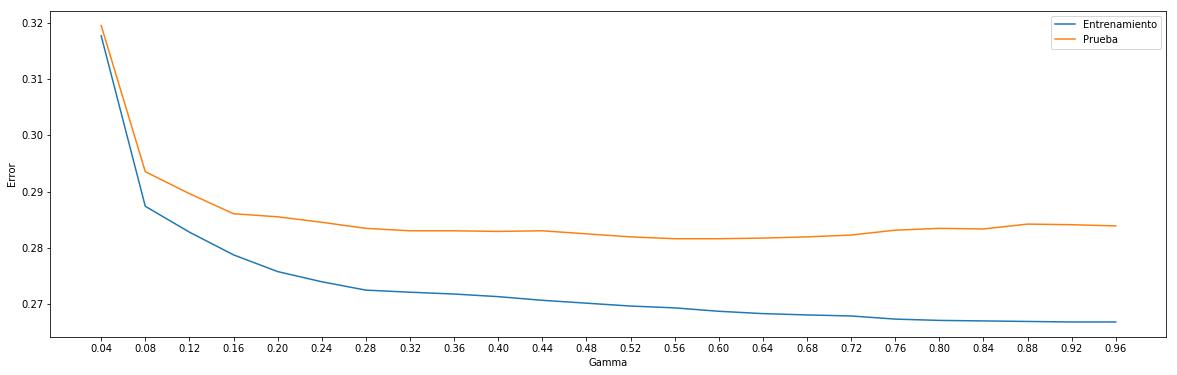

In [0]:
g_values = []
for i in range(1, 25):
    g_values.append(i/25)
print(g_values)
train_error = []
test_error = []

for i in g_values:
    svm = SVC(kernel='rbf', gamma = i)
    svm.fit(X_train, y_train)
    train_error.append(1 - svm.score(X_train, y_train))
    test_error.append(1 - svm.score(X_test, y_test))

pl.figure(figsize = (20, 6))
pl.plot(g_values, train_error, label="Entrenamiento")
pl.plot(g_values, test_error, label="Prueba")
pl.xticks(g_values)
pl.xlabel("Gamma")
pl.ylabel("Error")
pl.legend();

Gamma óptimo para la SVM es 0.16



1.c.3 Utilice los datos de entrenamiento/validación para explorar los parámetros de un clasificador Random Forest.


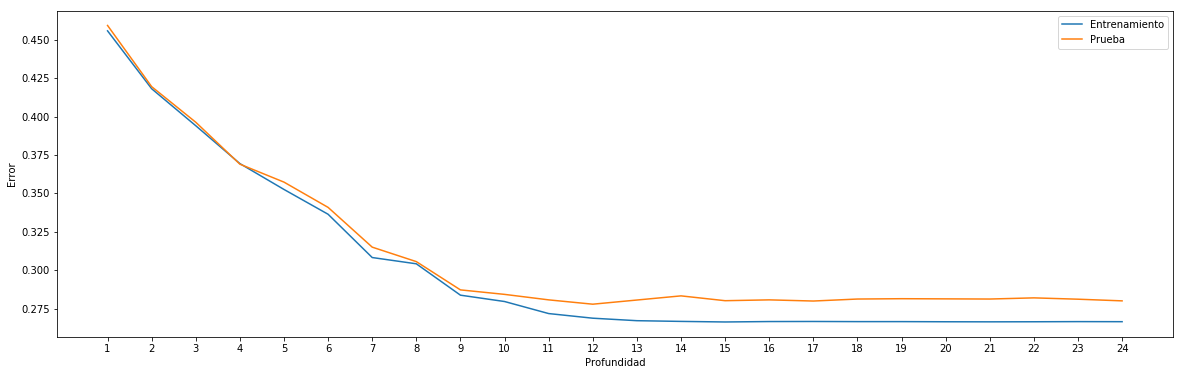

In [0]:
d_values = range(1, 25)
train_error = []
test_error = []

for i in d_values:
    rf = RandomForestClassifier(n_estimators=20, max_depth=i)
    rf.fit(X_train, y_train)
    train_error.append(1 - rf.score(X_train, y_train))
    test_error.append(1 - rf.score(X_test, y_test))

pl.figure(figsize = (20, 6))
pl.plot(d_values, train_error, label="Entrenamiento")
pl.plot(d_values, test_error, label="Prueba")
pl.xticks(d_values)
pl.xlabel("Profundidad")
pl.ylabel("Error")
pl.legend();

Profundidad óptima 12

1.c.4 Usando los mejores parámetros encontrados pruebe los dos tipos de modelo sobre el conjunto de prueba. Reporte diferentes métricas y matrices de confusión. Discuta los resultados obtenidos.

In [0]:
def list_cm(cm,classes):     #función para generar de una forma más visual la matriz de confusión
    if len(cm)==2:
        row_0 =['','Valor','Verdadero']
        row_1 =['-',classes[0],classes[1]]
        row_2 =[classes[0],cm[0,0],cm[1,0]]
        row_3 =[classes[1],cm[0,1],cm[1,1]]
        table = zip(row_0,row_1, row_2, row_3)
        headers = ['', '', 'Valor', 'Predicho']  
        return print(tabulate(table, headers=headers, floatfmt=".4f"))
    else:
        row_0 =['','Valor','Verdadero','']
        row_1 =['-',classes[0],classes[1],classes[2]]
        row_2 =[classes[0],cm[0,0],cm[1,0],cm[2,0]]
        row_3 =[classes[1],cm[0,1],cm[1,1],cm[2,1]]
        row_4 =[classes[2],cm[0,2],cm[1,2],cm[2,2]]
        table = zip(row_0,row_1, row_2, row_3, row_4)
        headers = ['', '', 'Valor', 'Predicho', '']  
        return print(tabulate(table, headers=headers, floatfmt=".4f"))   

##SVM

In [0]:
svm = SVC(kernel='rbf', gamma = 0.16)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
actions = ["MAINTAIN_DIRECTION", "TURN_LEFT", "TURN_RIGHT"]
list_cm(cnf_matrix, actions)
print()

print('Orden de las etiquetas: {}'.format(np.unique(actions)))
print('Accuracy: {}'.format(svm.score(X_test, y_test)))
print('Precisión por clase: {}'.format(precision_score(y_test, y_pred, average=None)))
print('Precisión macro: {}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall macro: {}'.format(recall_score(y_test, y_pred, average='macro')))
print('F1 macro: {}'.format(f1_score(y_test, y_pred, average='macro')))

                               Valor               Predicho
---------  ------------------  ------------------  ----------  ----------
           -                   MAINTAIN_DIRECTION  TURN_LEFT   TURN_RIGHT
Valor      MAINTAIN_DIRECTION  4143                319         270
Verdadero  TURN_LEFT           839                 1358        130
           TURN_RIGHT          743                 106         1628

Orden de las etiquetas: ['MAINTAIN_DIRECTION' 'TURN_LEFT' 'TURN_RIGHT']
Accuracy: 0.7475880872483222
Precisión por clase: [0.72366812 0.76163769 0.80276134]
Precisión macro: 0.7626890509271131
Recall macro: 0.7054530003152387
F1 macro: 0.7253225406616214


##RF

In [0]:
rf = RandomForestClassifier(n_estimators=20, max_depth=12)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
actions = ["MAINTAIN_DIRECTION", "TURN_LEFT", "TURN_RIGHT"]
list_cm(cnf_matrix, actions)
print()

print('Orden de las etiquetas: {}'.format(np.unique(actions)))
print('Accuracy: {}'.format(rf.score(X_test, y_test)))
print('Precisión por clase: {}'.format(precision_score(y_test, y_pred, average=None)))
print('Precisión macro: {}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall macro: {}'.format(recall_score(y_test, y_pred, average='macro')))
print('F1 macro: {}'.format(f1_score(y_test, y_pred, average='macro')))

                               Valor               Predicho
---------  ------------------  ------------------  ----------  ----------
           -                   MAINTAIN_DIRECTION  TURN_LEFT   TURN_RIGHT
Valor      MAINTAIN_DIRECTION  4024                236         376
Verdadero  TURN_LEFT           887                 1262        59
           TURN_RIGHT          678                 347         1374

Orden de las etiquetas: ['MAINTAIN_DIRECTION' 'TURN_LEFT' 'TURN_RIGHT']
Accuracy: 0.7205452775073028
Precisión por clase: [0.71998569 0.68401084 0.75953566]
Precisión macro: 0.7211773937785684
Recall macro: 0.670762086120572
F1 macro: 0.6876269569801794


Ambos modelos tienen una exactitud muy similar, el SVM parece un poco superior, pero en términos generales consideramos que ninguno de los dos logra resultados considerablemente buenos (al rededor del 72% de exactitud), los dos se "equivocan" de maneras similares al elegir la dirección esperada.

### 1.d Agente basado en un clasificador

Utilice los modelos creados en el ítem anterior para crear un agente que tome sus decisiones basado en un clasificador. Evalue el desempeño del agente en términos de la longitud máxima que alcanza en diferentes ambientes, de diferentes tamaños, con y sin obstáculos.

In [0]:
class ClassifierBasedAgent(AgentBase):

    def __init__(self):
        self.step = 0
        self.actions = []
        pass

    def begin_episode(self):
        pass

    def act(self, observation, reward):
        observation = np.array(observation)
        observation.flatten()
        prediction = svm.predict(observation.reshape(1, -1))
        #print(f"prediction {prediction}")
        action = ALL_SNAKE_ACTIONS[prediction[0]]
        self.step += 1
        return action
    
    def end_episode(self):
        pass

In [0]:
agent = ClassifierBasedAgent()

env = RestEnvironment(config=simple_field, verbose=0)
play(env, agent, num_episodes= 100, verbose=0, collect_data=False)
env = RestEnvironment(config=large_field, verbose=0)
play(env, agent, num_episodes= 3, verbose=0, collect_data=False)
env = RestEnvironment(config=large_field_obstacles1, verbose=0)
play(env, agent, num_episodes= 10, verbose=0, collect_data=False)
env = RestEnvironment(config=large_field_obstacles2, verbose=0)
play(env, agent, num_episodes= 10, verbose=0, collect_data=False)


Playing:
******* Episode   1 / 100 | Timesteps   34 | Fruits  6
******* Episode   2 / 100 | Timesteps   66 | Fruits 12
******* Episode   3 / 100 | Timesteps   81 | Fruits 15
******* Episode   4 / 100 | Timesteps 1000 | Fruits  6
******* Episode   5 / 100 | Timesteps   46 | Fruits 10
******* Episode   6 / 100 | Timesteps 1000 | Fruits  6
******* Episode   7 / 100 | Timesteps   38 | Fruits  9
******* Episode   8 / 100 | Timesteps   38 | Fruits 10
******* Episode   9 / 100 | Timesteps   95 | Fruits 13
******* Episode  10 / 100 | Timesteps   30 | Fruits  6
******* Episode  11 / 100 | Timesteps   72 | Fruits 12
******* Episode  12 / 100 | Timesteps   98 | Fruits 17
******* Episode  13 / 100 | Timesteps   57 | Fruits 10
******* Episode  14 / 100 | Timesteps   58 | Fruits 11
******* Episode  15 / 100 | Timesteps   51 | Fruits  9
******* Episode  16 / 100 | Timesteps   95 | Fruits 16
******* Episode  17 / 100 | Timesteps  108 | Fruits 16
******* Episode  18 / 100 | Timesteps  103 | Fruits 19


Viendo los resultados concluímos que el agente en algunas ocasiones se comportó de manera similar al masterMind, sin embargo en otras (varias) pareció llegar a algún estado en el que tomaba la decisión de quedarse dando vueltas en el tablero, creemos que se debe a la ambiguedad de los datos, por ejemplo en un tablero sin obstáculos toma deferentes decisiones viendo siempre la  misma observación.  Por los resultados decimos tambien que el escenario 3 resulta mucho maás difícil para el agente que el 4, aunque en los dos existen obstáculos.

## 2. Agente basado en un clasificador con características avanzadas
Vamos a extender el agente del ítem anterior para que use características más sofisticadas.


- **a)**  Cree una clase `AdvEnvironment` que extienda `Environment` y modifique el método `get_observation` para que retorne diferentes características a partir del campo de juego. Ejemplos de características:
  * Las 8 características del ítem anterior
  * Distancia de la cabeza a la fruta
  * Longitud de la serpiente
  * Distancia de la cabeza a la cola
  * etc.

In [0]:
data = []

In [0]:
class EnvironmentFull2(Environment):
    """
    Full observation environment. Same as base class environment, overloads 
    `get_observation` so that it returns the Field array and the Snake.
    (From Environment doc): Represents the RL environment for the Snake game that implements the game logic,
    provides rewards for the agent and keeps track of game statistics.
    """
    def __init__(self, config, verbose=0):
        super().__init__(config, verbose)

    def get_observation(self):
        """ Observe the state of the environment. """
        return (np.copy(self.field._cells), self.snake)
    
    def get_class_observation(self):
        """ 
        Observe the state of the environment. 
        Returns a tuple of 8 elements (x0, x2, ..., x7) where xi stores the state of the
        corresponding position:
        x_0: front_front_left
        x_1: front_front_center
        x_2: front_front_right
        x_3: front_left
        x_4: front_center
        x_5: front_right
        x_6: side_left
        x_7: side_right
        """
        if self.is_game_over:
            return (0, 0, 0, 0, 0, 0, 0)
        center = self.snake.head + self.snake.direction
        if self.snake.direction == Point(0,1):
            front_front_left = self.snake.head + Point(1,2)
            front_front_center = self.snake.head + Point(0,2)
            front_front_right = self.snake.head + Point(-1,2)
            front_left = self.snake.head + Point(1,1)
            front_center = self.snake.head + Point(0,1)
            front_right = self.snake.head + Point(-1,1)
            side_left = self.snake.head + Point(1,0)
            side_right = self.snake.head + Point(-1,0)
            
        if self.snake.direction == Point(0, -1):
            front_front_left = self.snake.head + Point(-1,-2)
            front_front_center = self.snake.head + Point(0,-2)
            front_front_right = self.snake.head + Point(1,-2)
            front_left = self.snake.head + Point(-1,-1)
            front_center = self.snake.head + Point(0,-1)
            front_right = self.snake.head + Point(1,-1)
            side_left = self.snake.head + Point(-1,0)
            side_right = self.snake.head + Point(1,0)
            
        elif self.snake.direction == Point(1, 0):
            front_front_left = self.snake.head + Point(2,-1)
            front_front_center = self.snake.head + Point(2,0)
            front_front_right = self.snake.head + Point(2,1)
            front_left = self.snake.head + Point(1,-1)
            front_center = self.snake.head + Point(1,0)
            front_right = self.snake.head + Point(1,1)
            side_left = self.snake.head + Point(0,-1)
            side_right = self.snake.head + Point(0,1)
            
        else:
            front_front_left = self.snake.head + Point(-2,1)
            front_front_center = self.snake.head + Point(-2,0)
            front_front_right = self.snake.head + Point(-2,-1)
            front_left = self.snake.head + Point(-1,1)
            front_center = self.snake.head + Point(-1,0)
            front_right = self.snake.head + Point(-1,-1)
            side_left = self.snake.head + Point(0,1)
            side_right = self.snake.head + Point(0,-1)

        my_problem = SnakeProblem(initial=(self.field._cells, self.snake))
        head = my_problem.initial[1].head
        for i in range(len(my_problem.initial[0])):
            for j in range(len(my_problem.initial[0][i])):
                if my_problem.initial[0][i, j] == 1:
                    fruit = Point(i, j)
        dist_to_fruit = manhattan(head, fruit)
        tail = my_problem.initial[1].tail
        dist_to_tail  = manhattan(head, tail)
        
        dirx= head[0]-fruit[0]
        diry= head[1]-fruit[1]
        snake_length=self.snake.length
            
        return (self.field[front_front_left], self.field[front_front_center], self.field[front_front_right], self.field[front_left], self.field[front_center],
                self.field[front_right], self.field[side_left], self.field[side_right], dist_to_fruit, dist_to_tail, dirx, diry, snake_length)
    
    def show_field(self):
        return self.field.__str__()

In [0]:
class AdvEnvironment(Environment):
    """
    Partial observation environment. Same as base class environment, overloads 
    `get_observation` so that only the cells around and in front of the snake head 
    are returned. 
    (From Environment doc): Represents the RL environment for the Snake game that implements the game logic,
    provides rewards for the agent and keeps track of game statistics.
    """
    def __init__(self, config, verbose=0):
        super().__init__(config, verbose)

    @property
    def observation_shape(self):
        """ Get the shape of the state observed at each timestep. """
        return 13

    def get_observation(self):
        """ 
        Observe the state of the environment. 
        Returns a tuple of 8 elements (x0, x2, ..., x7) where xi stores the state of the
        corresponding position:
        x_0: front_front_left
        x_1: front_front_center
        x_2: front_front_right
        x_3: front_left
        x_4: front_center
        x_5: front_right
        x_6: side_left
        x_7: side_right
        """
        if self.is_game_over:
            return (0, 0, 0, 0, 0, 0, 0)
        center = self.snake.head + self.snake.direction
        if self.snake.direction == Point(0,1):
            front_front_left = self.snake.head + Point(1,2)
            front_front_center = self.snake.head + Point(0,2)
            front_front_right = self.snake.head + Point(-1,2)
            front_left = self.snake.head + Point(1,1)
            front_center = self.snake.head + Point(0,1)
            front_right = self.snake.head + Point(-1,1)
            side_left = self.snake.head + Point(1,0)
            side_right = self.snake.head + Point(-1,0)
            
        elif self.snake.direction == Point(0, -1):
            front_front_left = self.snake.head + Point(-1,-2)
            front_front_center = self.snake.head + Point(0,-2)
            front_front_right = self.snake.head + Point(1,-2)
            front_left = self.snake.head + Point(-1,-1)
            front_center = self.snake.head + Point(0,-1)
            front_right = self.snake.head + Point(1,-1)
            side_left = self.snake.head + Point(-1,0)
            side_right = self.snake.head + Point(1,0)
            
        elif self.snake.direction == Point(1, 0):
            front_front_left = self.snake.head + Point(2,-1)
            front_front_center = self.snake.head + Point(2,0)
            front_front_right = self.snake.head + Point(2,1)
            front_left = self.snake.head + Point(1,-1)
            front_center = self.snake.head + Point(1,0)
            front_right = self.snake.head + Point(1,1)
            side_left = self.snake.head + Point(0,-1)
            side_right = self.snake.head + Point(0,1)
            
        else:
            front_front_left = self.snake.head + Point(-2,1)
            front_front_center = self.snake.head + Point(-2,0)
            front_front_right = self.snake.head + Point(-2,-1)
            front_left = self.snake.head + Point(-1,1)
            front_center = self.snake.head + Point(-1,0)
            front_right = self.snake.head + Point(-1,-1)
            side_left = self.snake.head + Point(0,1)
            side_right = self.snake.head + Point(0,-1)
            
        my_problem = SnakeProblem(initial=(self.field._cells, self.snake))
        
        
        head = my_problem.initial[1].head
        for i in range(len(my_problem.initial[0])):
            for j in range(len(my_problem.initial[0][i])):
                if my_problem.initial[0][i, j] == 1:
                    fruit = Point(i, j)
        dist_to_fruit = manhattan(head, fruit)
        tail = my_problem.initial[1].tail
        dist_to_tail  = manhattan(head, tail)
        
        dirx= head[0]-fruit[0]
        diry= head[1]-fruit[1]
        
        snake_lenght = env.snake.length
            
        return (self.field[front_front_left], self.field[front_front_center], self.field[front_front_right], self.field[front_left], self.field[front_center],
                self.field[front_right], self.field[side_left], self.field[side_right], dist_to_fruit, dist_to_tail, dirx, diry, snake_lenght)
    
    def show_field(self):
        return self.field.__str__()

- **b)** Cree un agente `AdvDataCollectionAgent` que recolecte los ejemplos de entrenamiento.

In [0]:
class AdvDataCollectionAgent(AgentBase):
    def __init__(self, env):
        self.step = 0
        self.c = 0
        self.actions = []
        pass

    def begin_episode(self):
        pass

    def act(self, observation, reward):
        if len(self.actions) == self.c:
            self.actions = self.plan(observation)
            self.c = 0
            if len(self.actions) == 0:
                env.is_episode_end = True
        if len(self.actions) == 0:
            action = SnakeAction.MAINTAIN_DIRECTION

        else:
            if self.actions[self.c] == "SnakeAction.TURN_RIGHT":
                action = SnakeAction.TURN_RIGHT
            elif self.actions[self.c] == "SnakeAction.TURN_LEFT":
                action = SnakeAction.TURN_LEFT
            elif self.actions[self.c] == "SnakeAction.MAINTAIN_DIRECTION":
                action = SnakeAction.MAINTAIN_DIRECTION
            self.step += 1
            self.c += 1
        return action
    
    def plan(self, observation):
        my_problem = SnakeProblem(initial=(env.field._cells, env.snake))
        plan = solveProblemAStar(my_problem)
        return plan

    def end_episode(self):
        pass

In [0]:
agent =  AdvDataCollectionAgent(env)
env = EnvironmentFull2(config=simple_field, verbose=0)
play(env, agent, num_episodes= 100, verbose=0, collect_data=True)
env = EnvironmentFull2(config=large_field, verbose=0)
play(env, agent, num_episodes= 100, verbose=0, collect_data=True)
env = EnvironmentFull2(config=large_field_obstacles1, verbose=0)
play(env, agent, num_episodes= 100, verbose=0, collect_data=True)
env = EnvironmentFull2(config=large_field_obstacles2, verbose=0)
play(env, agent, num_episodes= 100, verbose=0, collect_data=True)


Playing:
******* Episode   1 / 100 | Timesteps   37 | Fruits  9
******* Episode   2 / 100 | Timesteps   43 | Fruits 11
******* Episode   3 / 100 | Timesteps   77 | Fruits 18
******* Episode   4 / 100 | Timesteps   43 | Fruits 11
******* Episode   5 / 100 | Timesteps   45 | Fruits 15
******* Episode   6 / 100 | Timesteps   15 | Fruits  6
******* Episode   7 / 100 | Timesteps   53 | Fruits 12
******* Episode   8 / 100 | Timesteps   48 | Fruits 11
******* Episode   9 / 100 | Timesteps   47 | Fruits 10
******* Episode  10 / 100 | Timesteps   55 | Fruits 15
******* Episode  11 / 100 | Timesteps   61 | Fruits 15
******* Episode  12 / 100 | Timesteps   63 | Fruits 15
******* Episode  13 / 100 | Timesteps   49 | Fruits 16
******* Episode  14 / 100 | Timesteps   19 | Fruits  8
******* Episode  15 / 100 | Timesteps   39 | Fruits 12
******* Episode  16 / 100 | Timesteps   43 | Fruits 14
******* Episode  17 / 100 | Timesteps  101 | Fruits 21
******* Episode  18 / 100 | Timesteps   60 | Fruits 13


In [0]:
data = pd.DataFrame(data)
print(np.shape(data))

(31786, 14)


- **c)** Repita el punto 1.c con las nuevas características


### Entrenamiento del modelo de clasificación

 Dividir los ejemplos recolectados en entrenamiento/validación y prueba. 


In [0]:
y = data[13]
del data[13]
X = data
print(np.shape(y))
print(np.shape(X))

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=y)

(31786,)
(31786, 13)


In [0]:
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(22250, 13)
(22250,)
(9536, 13)
(9536,)


Utilizar los datos de entrenamiento/validación para explorar los parámetros de un clasificador SVM.

[0.02857142857142857, 0.05714285714285714, 0.08571428571428572, 0.11428571428571428, 0.14285714285714285, 0.17142857142857143, 0.2, 0.22857142857142856, 0.2571428571428571, 0.2857142857142857, 0.3142857142857143, 0.34285714285714286, 0.37142857142857144, 0.4, 0.42857142857142855, 0.45714285714285713, 0.4857142857142857, 0.5142857142857142, 0.5428571428571428, 0.5714285714285714, 0.6, 0.6285714285714286, 0.6571428571428571, 0.6857142857142857, 0.7142857142857143, 0.7428571428571429, 0.7714285714285715, 0.8, 0.8285714285714286, 0.8571428571428571, 0.8857142857142857, 0.9142857142857143, 0.9428571428571428, 0.9714285714285714]


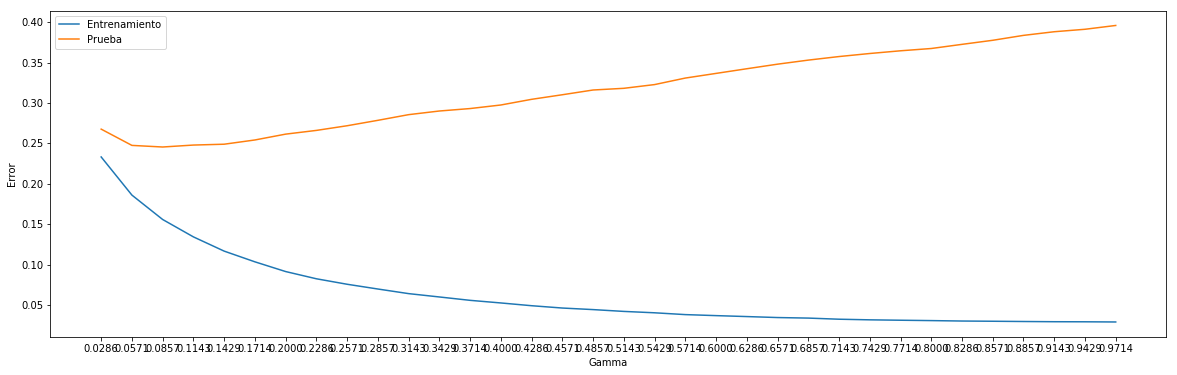

In [0]:
g_values = []
for i in range(1, 35):
    g_values.append(i/35)
print(g_values)
train_error = []
test_error = []

for i in g_values:
    svm = SVC(kernel='rbf', gamma = i)
    svm.fit(X_train, y_train)
    train_error.append(1 - svm.score(X_train, y_train))
    test_error.append(1 - svm.score(X_test, y_test))

pl.figure(figsize = (20, 6))
pl.plot(g_values, train_error, label="Entrenamiento")
pl.plot(g_values, test_error, label="Prueba")
pl.xticks(g_values)
pl.xlabel("Gamma")
pl.ylabel("Error")
pl.legend();

El codo parece ser en Gamma=0.057

Utilizar los datos de entrenamiento/validación para explorar los parámetros de un clasificador Random Forest.

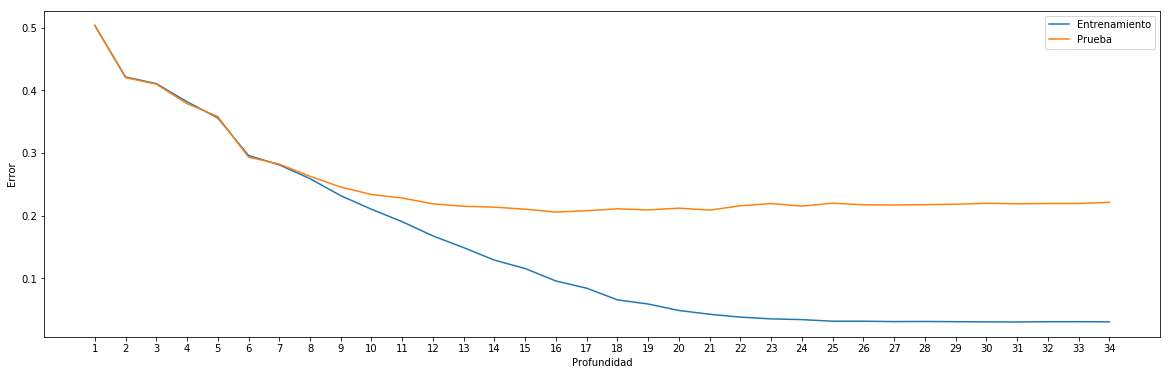

In [0]:
d_values = range(1, 35)
train_error = []
test_error = []

for i in d_values:
    rf = RandomForestClassifier(n_estimators=20, max_depth=i)
    rf.fit(X_train, y_train)
    train_error.append(1 - rf.score(X_train, y_train))
    test_error.append(1 - rf.score(X_test, y_test))

pl.figure(figsize = (20, 6))
pl.plot(d_values, train_error, label="Entrenamiento")
pl.plot(d_values, test_error, label="Prueba")
pl.xticks(d_values)
pl.xlabel("Profundidad")
pl.ylabel("Error")
pl.legend();

Escogimos 16 como altura óptima

Usando los mejores parámetros encontrados prpbar los dos tipos de modelo sobre el conjunto de prueba, reportando diferentes métricas y matrices de confusión. Discuta los resultados obtenidos.

##SVM

In [0]:
svm = SVC(kernel='rbf', gamma = 0.057)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
actions = ["MAINTAIN_DIRECTION", "TURN_LEFT", "TURN_RIGHT"]
list_cm(cnf_matrix, actions)
print()

print('Orden de las etiquetas: {}'.format(np.unique(actions)))
print('Accuracy: {}'.format(svm.score(X_test, y_test)))
print('Precisión por clase: {}'.format(precision_score(y_test, y_pred, average=None)))
print('Precisión macro: {}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall macro: {}'.format(recall_score(y_test, y_pred, average='macro')))
print('F1 macro: {}'.format(f1_score(y_test, y_pred, average='macro')))

                               Valor               Predicho
---------  ------------------  ------------------  ----------  ----------
           -                   MAINTAIN_DIRECTION  TURN_LEFT   TURN_RIGHT
Valor      MAINTAIN_DIRECTION  4120                322         290
Verdadero  TURN_LEFT           831                 1352        144
           TURN_RIGHT          673                 100         1704

Orden de las etiquetas: ['MAINTAIN_DIRECTION' 'TURN_LEFT' 'TURN_RIGHT']
Accuracy: 0.75251677852349
Precisión por clase: [0.73257468 0.7621195  0.79700655]
Precisión macro: 0.763900244021617
Recall macro: 0.713200775547637
F1 macro: 0.7311623071939283


##RF

In [0]:
rf = RandomForestClassifier(n_estimators=20, max_depth=16)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
actions = ["MAINTAIN_DIRECTION", "TURN_LEFT", "TURN_RIGHT"]
list_cm(cnf_matrix, actions)
print()

print('Orden de las etiquetas: {}'.format(np.unique(actions)))
print('Accuracy: {}'.format(rf.score(X_test, y_test)))
print('Precisión por clase: {}'.format(precision_score(y_test, y_pred, average=None)))
print('Precisión macro: {}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall macro: {}'.format(recall_score(y_test, y_pred, average='macro')))
print('F1 macro: {}'.format(f1_score(y_test, y_pred, average='macro')))

                               Valor               Predicho
---------  ------------------  ------------------  ----------  ----------
           -                   MAINTAIN_DIRECTION  TURN_LEFT   TURN_RIGHT
Valor      MAINTAIN_DIRECTION  4283                262         187
Verdadero  TURN_LEFT           791                 1412        124
           TURN_RIGHT          783                 94          1600

Orden de las etiquetas: ['MAINTAIN_DIRECTION' 'TURN_LEFT' 'TURN_RIGHT']
Accuracy: 0.7649958053691275
Precisión por clase: [0.73126174 0.79864253 0.83725798]
Precisión macro: 0.7890540840476493
Recall macro: 0.7192822158089641
F1 macro: 0.7426119329930004


Paso algo similar a la prueba anterior, aunque en esta prueba parece que al random forest(aunque por muy poco) le fue mejor que al SVM. Este empezó a dar un error muy alto muy rápidamente  (En las gráficas)

- **d)** Cree un agente `ClassifierBasedAgent` basado en el nuevo clasificador. Evalue el desempeño del agente en términos de la longitud máxima que alcanza en diferentes ambientes, de diferentes tamaños, con y sin obstáculos. Contraste los resultados con los obtenidos con el agente del punto anterior. Discuta.

In [0]:
svm = SVC(kernel='rbf', gamma = 0.057)
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.057, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
class ClassifierBasedAgent2(AgentBase):

    def __init__(self):
        self.step = 0
        self.actions = []
        pass

    def begin_episode(self):
        pass

    def act(self, observation, reward):
        observation = np.array(observation)
        observation.flatten()
        prediction = svm.predict(observation.reshape(1, -1))
        #print(f"prediction {prediction}")
        if prediction[0]>2:
            prediction[0]=0
        action = ALL_SNAKE_ACTIONS[prediction[0]]
        self.step += 1
        return action
    
    def end_episode(self):
        pass

In [0]:
agent = ClassifierBasedAgent2()
env = AdvEnvironment(config=simple_field, verbose=0)
play(env, agent, num_episodes= 100, verbose=0, collect_data=False)
env = AdvEnvironment(config=large_field, verbose=0)
play(env, agent, num_episodes= 10, verbose=0, collect_data=False)
env = AdvEnvironment(config=large_field_obstacles1, verbose=0)
play(env, agent, num_episodes= 10, verbose=0, collect_data=False)
env = AdvEnvironment(config=large_field_obstacles2, verbose=0)
play(env, agent, num_episodes= 10, verbose=0, collect_data=False)


Playing:
******* Episode   1 / 100 | Timesteps   53 | Fruits 12
******* Episode   2 / 100 | Timesteps   40 | Fruits  5
******* Episode   3 / 100 | Timesteps 1000 | Fruits  2
******* Episode   4 / 100 | Timesteps   22 | Fruits  5
******* Episode   5 / 100 | Timesteps 1000 | Fruits  2
******* Episode   6 / 100 | Timesteps   41 | Fruits  6
******* Episode   7 / 100 | Timesteps   41 | Fruits  6
******* Episode   8 / 100 | Timesteps 1000 | Fruits  2
******* Episode   9 / 100 | Timesteps   29 | Fruits  3
******* Episode  10 / 100 | Timesteps    9 | Fruits  2
******* Episode  11 / 100 | Timesteps 1000 | Fruits  0
******* Episode  12 / 100 | Timesteps   15 | Fruits  3
******* Episode  13 / 100 | Timesteps   21 | Fruits  5
******* Episode  14 / 100 | Timesteps 1000 | Fruits  4
******* Episode  15 / 100 | Timesteps 1000 | Fruits  2
******* Episode  16 / 100 | Timesteps   42 | Fruits  8
******* Episode  17 / 100 | Timesteps 1000 | Fruits  3
******* Episode  18 / 100 | Timesteps 1000 | Fruits  6


In [0]:
rf = RandomForestClassifier(n_estimators=20, max_depth=16)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=16, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

##Usando las probalbilidades de cada acción para cambiarlas cuando parezca que se va a quedar en loop

In [0]:
class ClassifierBasedAgent3_proba(AgentBase):

    def __init__(self):
        self.step = 0
        self.actions = []
        pass

    def begin_episode(self):
        pass

    def act(self, observation, reward):
        observation = np.array(observation)
        observation.flatten()
        #prediction = rf.predict(observation.reshape(1, -1))
        #prediction_proba = rf.predict_proba(observation.reshape(1, -1))
        #print(f"prediction_proba {prediction_proba}")
        #print(f"prediction {prediction}")
            
    
        pp = rf.predict_proba(observation.reshape(1, -1))[0]
        #print(f"prediction_proba {pp}")
        #print(f"prediction {prediction}")
        maxi=0
        sec=0
        if(pp[0]>pp[1] and pp[0]>pp[2]):
            maxi=0
            if(pp[1]>pp[2]):
                sec=1
            else:
                sec=2                    
        if(pp[1]>pp[0] and pp[1]>pp[2]):
            maxi=1
            if(pp[0]>pp[2]):
                sec=0
            else:
                sec=2
        if(pp[2]>pp[0] and pp[2]>pp[1]):
            maxi=2
            if(pp[0]>pp[1]):
                sec=0
            else:
                sec=1
                
        if(maxi<=0.5):
            sel=random.choice([maxi, sec])
            action = ALL_SNAKE_ACTIONS[sel]
        else:    
            action = ALL_SNAKE_ACTIONS[maxi]
 

        #action = ALL_SNAKE_ACTIONS[prediction[0]]
        self.step += 1
        return action
    
    def end_episode(self):
        pass

In [0]:
agent = ClassifierBasedAgent3_proba()
env = AdvEnvironment(config=simple_field, verbose=0)
play(env, agent, num_episodes= 100, verbose=0, collect_data=False)
env = AdvEnvironment(config=large_field, verbose=0)
play(env, agent, num_episodes= 10, verbose=0, collect_data=False)
env = AdvEnvironment(config=large_field_obstacles1, verbose=0)
play(env, agent, num_episodes= 10, verbose=0, collect_data=False)
env = AdvEnvironment(config=large_field_obstacles2, verbose=0)
play(env, agent, num_episodes= 10, verbose=0, collect_data=False)


Playing:
******* Episode   1 / 100 | Timesteps    6 | Fruits  0
******* Episode   2 / 100 | Timesteps  105 | Fruits  3
******* Episode   3 / 100 | Timesteps   31 | Fruits  4
******* Episode   4 / 100 | Timesteps   30 | Fruits  3
******* Episode   5 / 100 | Timesteps   34 | Fruits  6
******* Episode   6 / 100 | Timesteps   18 | Fruits  3
******* Episode   7 / 100 | Timesteps   32 | Fruits  5
******* Episode   8 / 100 | Timesteps   53 | Fruits  9
******* Episode   9 / 100 | Timesteps   23 | Fruits  4
******* Episode  10 / 100 | Timesteps   46 | Fruits  4
******* Episode  11 / 100 | Timesteps   51 | Fruits  5
******* Episode  12 / 100 | Timesteps   15 | Fruits  2
******* Episode  13 / 100 | Timesteps   13 | Fruits  4
******* Episode  14 / 100 | Timesteps   33 | Fruits  4
******* Episode  15 / 100 | Timesteps   19 | Fruits  4
******* Episode  16 / 100 | Timesteps   30 | Fruits  4
******* Episode  17 / 100 | Timesteps   26 | Fruits  4
******* Episode  18 / 100 | Timesteps   34 | Fruits  5


##Sin usar las probabilidad

In [0]:
class ClassifierBasedAgent3(AgentBase):

    def __init__(self):
        self.step = 0
        self.actions = []
        pass

    def begin_episode(self):
        pass

    def act(self, observation, reward):
        observation = np.array(observation)
        observation.flatten()
        prediction = rf.predict(observation.reshape(1, -1))
        #prediction_proba = rf.predict_proba(observation.reshape(1, -1))
        #print(f"prediction_proba {prediction_proba}")
        #print(f"prediction {prediction}")
            
    
       

        action = ALL_SNAKE_ACTIONS[prediction[0]]
        self.step += 1
        return action
    
    def end_episode(self):
        pass

In [0]:
agent = ClassifierBasedAgent3()
env = AdvEnvironment(config=simple_field, verbose=0)
play(env, agent, num_episodes= 100, verbose=0, collect_data=False)
env = AdvEnvironment(config=large_field, verbose=0)
play(env, agent, num_episodes= 10, verbose=0, collect_data=False)
env = AdvEnvironment(config=large_field_obstacles1, verbose=0)
play(env, agent, num_episodes= 10, verbose=0, collect_data=False)
env = AdvEnvironment(config=large_field_obstacles2, verbose=0)
play(env, agent, num_episodes= 10, verbose=0, collect_data=False)


Playing:
******* Episode   1 / 100 | Timesteps   22 | Fruits  5
******* Episode   2 / 100 | Timesteps   51 | Fruits  9
******* Episode   3 / 100 | Timesteps 1000 | Fruits  0
******* Episode   4 / 100 | Timesteps   52 | Fruits  9
******* Episode   5 / 100 | Timesteps   58 | Fruits 11
******* Episode   6 / 100 | Timesteps   33 | Fruits  8
******* Episode   7 / 100 | Timesteps 1000 | Fruits  0
******* Episode   8 / 100 | Timesteps   16 | Fruits  3
******* Episode   9 / 100 | Timesteps   39 | Fruits 10
******* Episode  10 / 100 | Timesteps   43 | Fruits  9
******* Episode  11 / 100 | Timesteps   42 | Fruits  7
******* Episode  12 / 100 | Timesteps   29 | Fruits  5
******* Episode  13 / 100 | Timesteps 1000 | Fruits  0
******* Episode  14 / 100 | Timesteps   55 | Fruits 13
******* Episode  15 / 100 | Timesteps   52 | Fruits 11
******* Episode  16 / 100 | Timesteps   35 | Fruits  8
******* Episode  17 / 100 | Timesteps 1000 | Fruits  0
******* Episode  18 / 100 | Timesteps   26 | Fruits  7


Como esperabamos el random forest (sin la probabilidad) obtuvo mejores resultados, concluimos que es un mejor modelo para casos en los que se puede presentar ambiguedad en los datos.

El Agente que recibe datos adicionales (Distancia a la cola, distancia a la fruta, tamaño, distancia en x, distancia en y) Es un poco mejor que el agente anterior, pero aun asi no parece lograr resultados optimos, intentamos hacer uso de las probabilidades para ver si obteníamos mejores resultadosv(sobre todo en los casos en los que se queda dando vueltas, cosa que pasa seguido) esto logra que no se quede dando vueltas sin más, pero también pasa que en ocasiones en las que era "bueno" bajó el rendimiento. Arriba están los resultados utilizando random forest con y sin probabilidad y se puede evidenciar.